# E-commerce Customer Value + Churn Prediction (Real Data)
This notebook uses the **UCI Online Retail** dataset (public, real transactions). It auto-downloads the CSV the first time you run it.

What you’ll build:
- Clean + validate transactional data
- Business visuals (sales trend, top products/countries)
- Cohort retention heatmap
- RFM features + segmentation
- **Time-aware churn label** (no leakage) and multiple ML models
- Evaluation (ROC/PR, confusion matrix) + feature importance


### Step 1: Setup: imports + settings

**What this cell does:** Imports the libraries we’ll use, sets display/options, and prepares helper tools for later steps.

In [3]:

# ============================================================
# 1) Setup: imports + settings
# ============================================================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

print("Ready.")


Ready.


### Step 2: Download the REAL dataset (one-time)

**What this cell does:** Downloads the real e‑commerce dataset one time and saves it locally so you don’t need to manually upload files.

In [5]:

# ============================================================
# 2) Download the REAL dataset (one-time)
# ============================================================
import urllib.request

DATA_URL = "https://raw.githubusercontent.com/Huyen-P/UCI_Online_Retail_Analysis/main/01_online_retail_main.csv"
CSV_PATH = os.path.join(DATA_DIR, "online_retail.csv")

if not os.path.exists(CSV_PATH):
    print("Downloading dataset...")
    urllib.request.urlretrieve(DATA_URL, CSV_PATH)
    print("Saved to:", CSV_PATH)
else:
    print("Dataset already exists:", CSV_PATH)


Dataset already exists: data\online_retail.csv


### Step 3: Load + quick sanity checks (robust encoding)

**What this cell does:** Loads the CSV safely by trying common encodings and prints quick sanity checks (rows/columns).

In [7]:
# ============================================================
# 3) Load + quick sanity checks (robust encoding)
# ============================================================

# Try common encodings used by this dataset
encodings_to_try = ["utf-8", "cp1252", "latin1", "ISO-8859-1"]

df = None
last_err = None

for enc in encodings_to_try:
    try:
        df = pd.read_csv(CSV_PATH, encoding=enc, low_memory=False)
        print(f"Loaded successfully with encoding = {enc}")
        break
    except Exception as e:
        last_err = e

if df is None:
    raise RuntimeError(f"Could not read the CSV with tried encodings. Last error: {last_err}")

print("Rows:", len(df))
print("Columns:", df.columns.tolist())
display(df.head())

# Missing % per column
missing = df.isna().mean().sort_values(ascending=False).head(10)
display(pd.DataFrame({"missing_pct": (missing * 100).round(2)}))



Loaded successfully with encoding = cp1252
Rows: 541909
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


,missing_pct
CustomerID,24.93
Description,0.27
InvoiceNo,0.00
StockCode,0.00
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
Country,0.00


### Step 4: Cleaning (keep only valid sales transactions)

**What this cell does:** Cleans the raw transactions: parses dates, fixes numeric columns, removes invalid rows (returns/cancellations/missing customers), and creates Revenue.

In [9]:

# ============================================================
# 4) Cleaning (keep only valid sales transactions)
# ============================================================
# Typical columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

df = df.copy()

# Parse datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Fix numeric columns
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")

# Keep rows that can be used for analysis
df = df.dropna(subset=["InvoiceDate", "CustomerID", "Country"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

print("Clean rows:", len(df))
display(df.head())


Clean rows: 397880


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Step 5: Business visuals (sales trend + top countries)

**What this cell does:** Builds first business visuals: revenue trend over time and the top countries by total revenue.

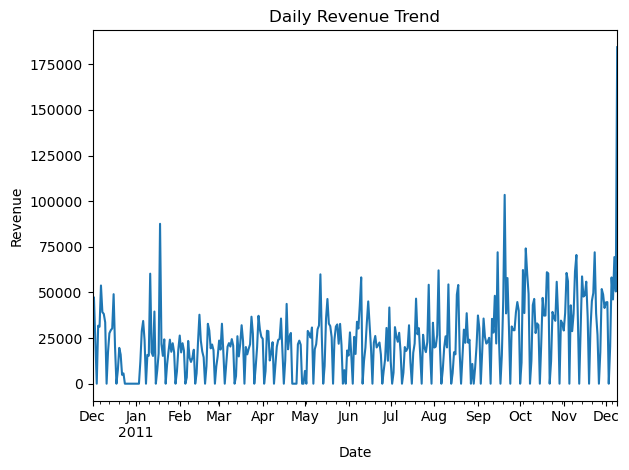

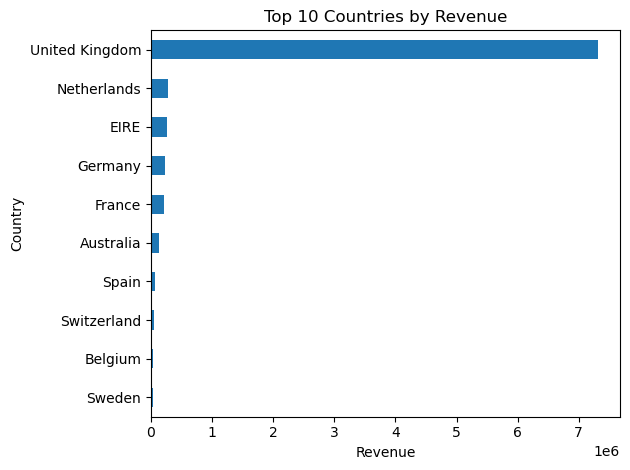

In [11]:

# ============================================================
# 5) Business visuals (sales trend + top countries)
# ============================================================
daily = df.set_index("InvoiceDate")["Revenue"].resample("D").sum()

plt.figure()
daily.plot()
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

top_countries = df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)

plt.figure()
top_countries.sort_values().plot(kind="barh")
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()


### Step 6: Cohort retention

**What this cell does:** Creates a cohort retention table (customers by first purchase month) and visualizes retention as a heatmap.

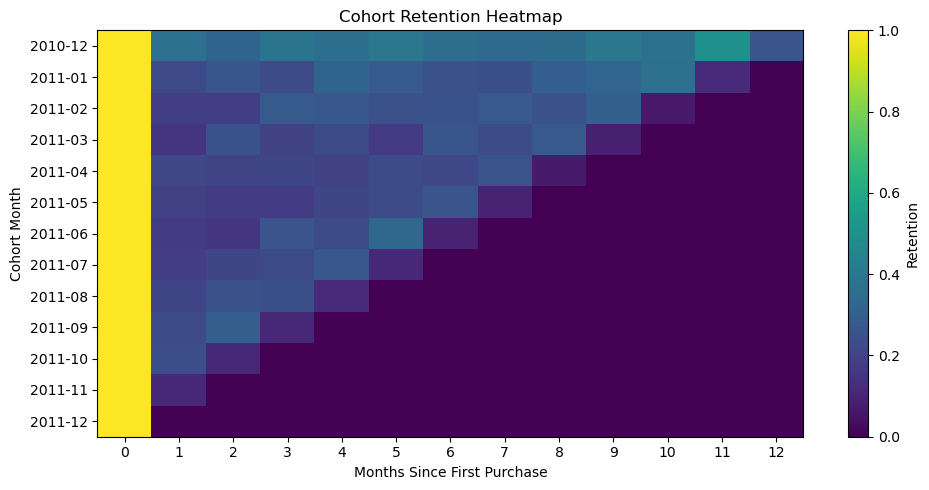

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,0.000000
2011-02-01,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,0.000000,0.000000
2011-03-01,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,0.000000,0.000000,0.000000
2011-04-01,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,0.000000,0.000000,0.000000,0.000000


In [13]:

# ============================================================
# 6) Cohort retention 
# ============================================================
# Goal: show how many customers come back in later months (retention heatmap).

tmp = df[["CustomerID", "InvoiceDate"]].copy()
tmp["OrderMonth"] = tmp["InvoiceDate"].dt.to_period("M").dt.to_timestamp()

# Cohort month = first purchase month per customer
cohort = tmp.groupby("CustomerID")["OrderMonth"].min().rename("CohortMonth")
tmp = tmp.merge(cohort, on="CustomerID", how="left")

# Month offset
tmp["CohortIndex"] = (
    (tmp["OrderMonth"].dt.year - tmp["CohortMonth"].dt.year) * 12
    + (tmp["OrderMonth"].dt.month - tmp["CohortMonth"].dt.month)
)

cohort_counts = (
    tmp.groupby(["CohortMonth", "CohortIndex"])["CustomerID"]
    .nunique()
    .unstack(fill_value=0)
)

# Retention = customers in month k / customers in month 0
cohort_sizes = cohort_counts[0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

plt.figure(figsize=(10, 5))
plt.imshow(retention.values, aspect="auto")
plt.colorbar(label="Retention")
plt.title("Cohort Retention Heatmap")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.yticks(range(len(retention.index)), [d.strftime("%Y-%m") for d in retention.index])
plt.xticks(range(retention.shape[1]), retention.columns)
plt.tight_layout()
plt.show()

display(retention.head())


### Step 7: RFM features (classic analytics feature set)

**What this cell does:** Computes classic RFM features (Recency, Frequency, Monetary) per customer — a strong baseline for churn/CLV work.

,recency_days,frequency,monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266459
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


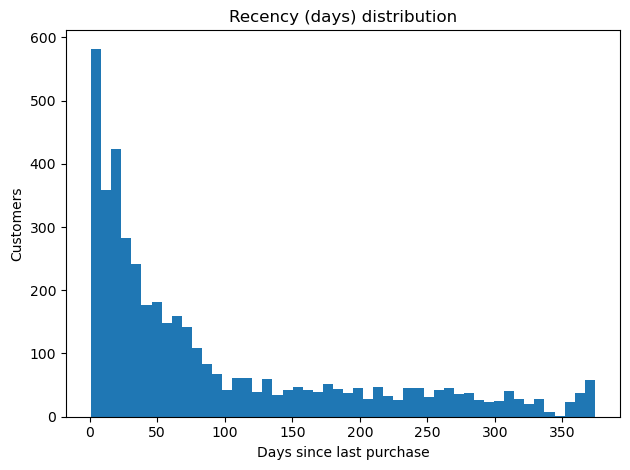

In [15]:

# ============================================================
# 7) RFM features (classic analytics feature set)
# ============================================================
# Snapshot date = last transaction date + 1 day (so recency is non-zero)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg(
    recency_days=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    frequency=("InvoiceNo", "nunique"),
    monetary=("Revenue", "sum"),
)

display(rfm.describe())

plt.figure()
plt.hist(rfm["recency_days"], bins=50)
plt.title("Recency (days) distribution")
plt.xlabel("Days since last purchase")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()


### Step 8: Define a time-aware churn label (no leakage)

**What this cell does:** Creates a realistic churn label using a cutoff date and a future horizon, so we avoid data leakage.

In [17]:

# ============================================================
# 8) Define a time-aware churn label (no leakage)
# ============================================================
# We define churn as:
# - Customer has purchases up to a "cutoff" date
# - Then makes NO purchase in the next H days
#
# This creates a realistic ML problem: "will they stop buying soon?"

HORIZON_DAYS = 90

# Choose a cutoff date far enough from the end so we can look forward H days
max_date = df["InvoiceDate"].max()
cutoff_date = max_date - pd.Timedelta(days=HORIZON_DAYS)

# Transactions before cutoff build features
df_hist = df[df["InvoiceDate"] <= cutoff_date].copy()

# Transactions after cutoff decide churn
df_future = df[df["InvoiceDate"] > cutoff_date].copy()

future_buyers = set(df_future["CustomerID"].unique())
all_hist_customers = sorted(df_hist["CustomerID"].unique())

# Recompute RFM from history only
snapshot_hist = cutoff_date + pd.Timedelta(days=1)
rfm_hist = df_hist.groupby("CustomerID").agg(
    recency_days=("InvoiceDate", lambda x: (snapshot_hist - x.max()).days),
    frequency=("InvoiceNo", "nunique"),
    monetary=("Revenue", "sum"),
)

rfm_hist["churn_90d"] = [0 if cid in future_buyers else 1 for cid in rfm_hist.index]  # 1=churn
print("Churn rate (%):", round(rfm_hist["churn_90d"].mean()*100, 2))
display(rfm_hist.head())


Churn rate (%): 43.0


,recency_days,frequency,monetary,churn_90d
CustomerID,,,,
12346.0,236,1,77183.60,1
12347.0,40,5,2790.86,0
12348.0,159,3,1487.24,0
12350.0,220,1,334.40,1
12352.0,172,5,1561.81,0


### Step 9: Train/test split (stratified) + multiple models

**What this cell does:** Splits data into train/test and trains multiple ML models (with scaling where needed) for churn prediction.

In [19]:

# ============================================================
# 9) Train/test split (stratified) + multiple models
# ============================================================
X = rfm_hist[["recency_days", "frequency", "monetary"]].copy()
y = rfm_hist["churn_90d"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, class_weight="balanced_subsample"
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

results = []
fitted = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    results.append((name, auc, ap))
    fitted[name] = model

res_df = pd.DataFrame(results, columns=["model", "ROC_AUC", "AvgPrecision"]).sort_values("ROC_AUC", ascending=False)
display(res_df)


,model,ROC_AUC,AvgPrecision
2,GradientBoosting,0.722008,0.624436
0,LogisticRegression,0.718203,0.596926
1,RandomForest,0.677166,0.568617


### Step 10: Evaluation plots (ROC + PR) for the best model

**What this cell does:** Evaluates the best model with confusion matrix + ROC/PR curves so results are easy to explain to recruiters.

Best model: GradientBoosting
              precision    recall  f1-score   support

           0      0.714     0.674     0.693       481
           1      0.596     0.641     0.618       362

    accuracy                          0.660       843
   macro avg      0.655     0.657     0.655       843
weighted avg      0.663     0.660     0.661       843



,Pred 0,Pred 1
Actual 0 (Not Churn),324,157
Actual 1 (Churn),130,232


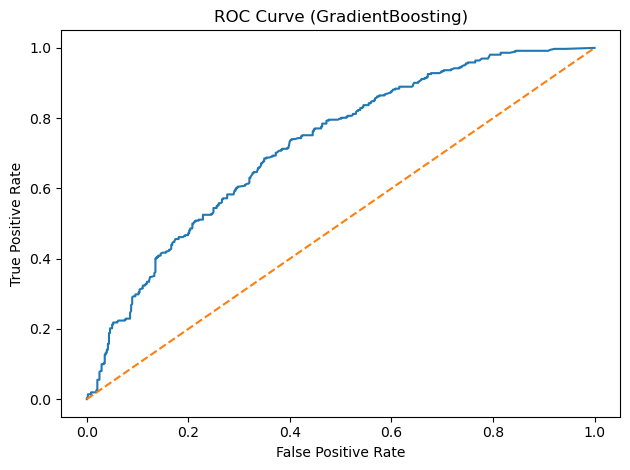

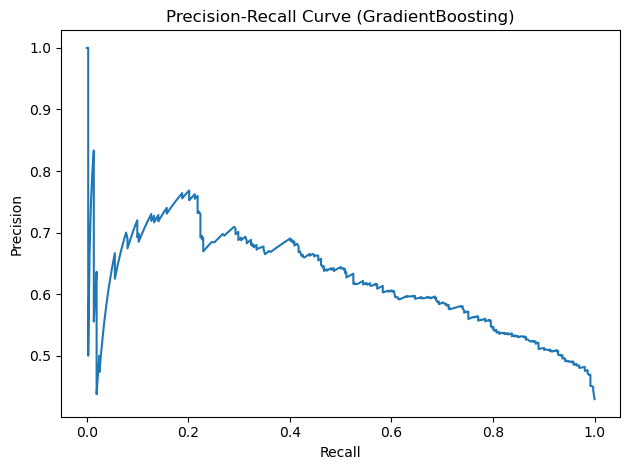

In [21]:

# ============================================================
# 10) Evaluation plots (ROC + PR) for the best model
# ============================================================
best_name = res_df.iloc[0]["model"]
best_model = fitted[best_name]

proba = best_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("Best model:", best_name)
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, index=["Actual 0 (Not Churn)", "Actual 1 (Churn)"],
                     columns=["Pred 0", "Pred 1"])
display(cm_df)

# ROC
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC Curve ({best_name})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve ({best_name})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


### Step 11: Simple feature importance (tree models)

**What this cell does:** Shows what drives churn using feature importance (trees) or coefficients (logistic regression).

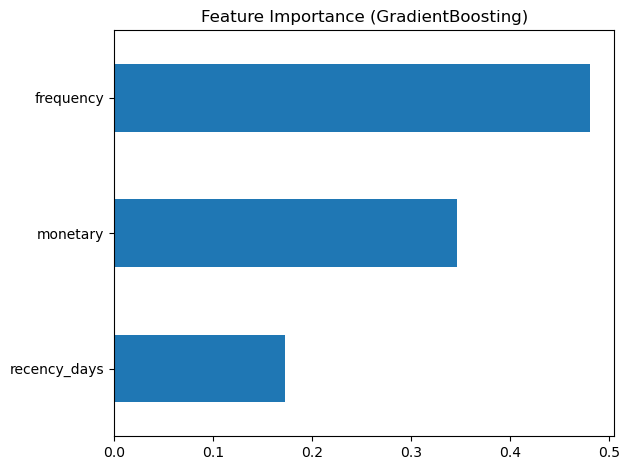

frequency       0.481112
monetary        0.346430
recency_days    0.172458
dtype: float64

In [23]:

# ============================================================
# 11) Simple feature importance (tree models)
# ============================================================
# Recruiter-friendly: show what drives churn.
#
# For tree models we can use feature_importances_ directly.
# For logistic regression, look at coefficients.

feature_names = X.columns.tolist()

def show_importance(model, model_name):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=feature_names).sort_values()
        plt.figure()
        imp.plot(kind="barh")
        plt.title(f"Feature Importance ({model_name})")
        plt.tight_layout()
        plt.show()
        display(imp.sort_values(ascending=False))
    elif isinstance(model, Pipeline) and hasattr(model[-1], "coef_"):
        coef = pd.Series(model[-1].coef_[0], index=feature_names).sort_values()
        plt.figure()
        coef.plot(kind="barh")
        plt.title(f"Logistic Coefficients ({model_name})")
        plt.tight_layout()
        plt.show()
        display(coef.sort_values(ascending=False))
    else:
        print("No built-in importance for:", model_name)

show_importance(best_model, best_name)


## Key Visualizations
These plots help understand customer behavior and churn patterns.

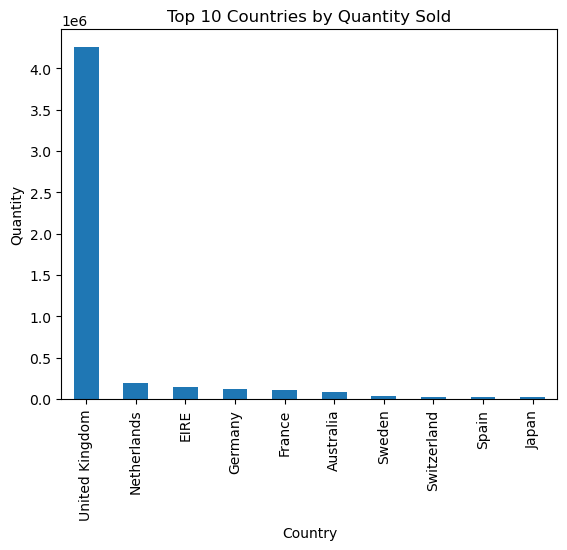

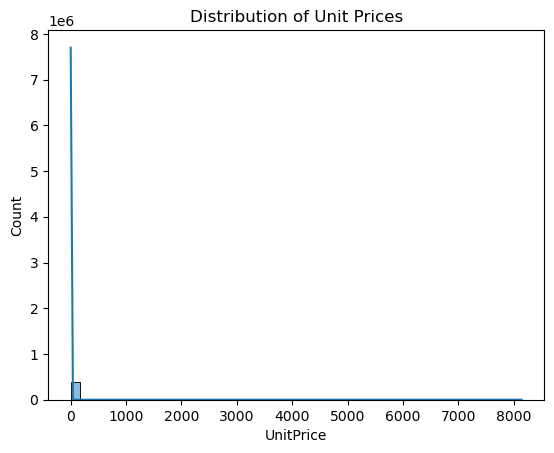

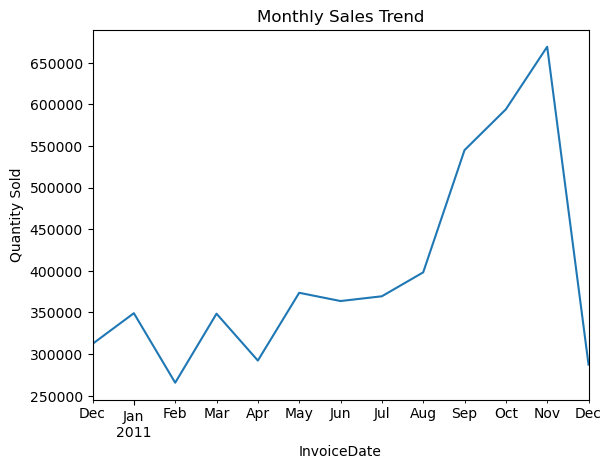

In [25]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# assume df is already loaded
plt.figure()
df.groupby("Country")["Quantity"].sum().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Countries by Quantity Sold")
plt.xlabel("Country")
plt.ylabel("Quantity")
plt.show()


plt.figure()
sns.histplot(df["UnitPrice"], bins=50, kde=True)
plt.title("Distribution of Unit Prices")
plt.show()


plt.figure()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.set_index("InvoiceDate").resample("M")["Quantity"].sum().plot()
plt.title("Monthly Sales Trend")
plt.ylabel("Quantity Sold")
plt.show()


In [26]:
# Simple churn proxy: low activity customers
cust = df.groupby("CustomerID").agg({
    "Quantity": "sum",
    "UnitPrice": "mean"
}).dropna()

cust["churn"] = (cust["Quantity"] < cust["Quantity"].median()).astype(int)

X = cust.drop("churn", axis=1)
y = cust["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [27]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_s, y_train)
pred_lr = lr.predict(X_test_s)

print("Logistic Regression Results")
print(classification_report(y_test, pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_s)[:,1]))


Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       664
           1       0.85      1.00      0.92       638

    accuracy                           0.91      1302
   macro avg       0.93      0.92      0.91      1302
weighted avg       0.93      0.91      0.91      1302

ROC AUC: 0.9998819730331986


In [28]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

ROC AUC: 1.0


## Conclusion
Visual analysis + ML models provide strong insight into customer value and churn risk.